## Посимвольная языковая модель.

В первом задании Вам нужно написать и обучить посимвольную нейронную языковую модель для вычисления вероятностей буквенных последовательностей (то есть слов). Такие модели используются в задачах словоизменения и распознавания/порождения звучащей речи. Для обучения модели используйте данные для русского языка из [репозитория](https://github.com/sigmorphon/conll2018/tree/master/task1/surprise).

**В процессе написания Вам нужно решить следующие проблемы:**
    
* как будет выглядеть обучающая выборка; что будет являться признаками, и что - метками классов.
* как сделать так, чтобы модель при предсказании символа учитывала все предыдущие символы слова.
* какие специальные символы нужно использовать.
* как передавать в модель текущее состояние рекуррентной сети

**Результаты:**

* предобработчик данных,
* генератор обучающих данных (батчей),
* обученная модель
* перплексия модели на настроечной выборке
* посимвольные вероятности слов в контрольной выборке

**Дополнительно:**

* дополнительный вход модели (часть речи слова, другие морфологические признаки), влияет ли его добавление на перплексию
* сравнение различных архитектур нейронной сети (FC, RNN, LSTM, QRNN, ...)

Подумайте, какие вспомогательные токены могут быть вам полезны. Выдайте им индексы от `0` до `len(AUXILIARY) - 1`

**План**
- Данные
    - Признаки: набор символов токена, заканчивается токеном END
    - Метки класса: набор символов того же токена, начинается с токена BEGIN
- Для учета всех предыдущих символов, при предсказании следующего символа, дополнительно мы должны передавать на вход предыдущий токен
- Специальные символы
    - BEGIN, END, MASK, UNK
- (???) Как передавать в модель текущее состояние рекуррентной сети

In [23]:
# it is better to do all imports at the first cell
from pathlib import Path
from itertools import islice
from operator import itemgetter
from functools import partial
from argparse import Namespace

from tqdm import tqdm_notebook
from tensorboardX import SummaryWriter

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [24]:
# Uncomment to download data
# !wget https://raw.githubusercontent.com/sigmorphon/conll2018/blob/master/task1/surprise/russian-train-high
# !wget https://raw.githubusercontent.com/sigmorphon/conll2018/blob/master/task1/surprise/russian-dev
# !wget https://raw.githubusercontent.com/sigmorphon/conll2018/blob/master/task1/surprise/russian-test

In [25]:
DATA_PATH = Path('./data')
MODELS_PATH = Path('./models')

In [26]:
file_paths = {'train': DATA_PATH/'russian-train-high',
              'val': DATA_PATH/'russian-dev',
              'test': DATA_PATH/'russian-test'}

In [27]:
class Vocabulary:
    def __init__(self, token_to_idx=None):
        # Initialize mapping (token -> idx) if empty
        if token_to_idx is None:
            token_to_idx = {}
        
        # Generate 2 mappings (tokens -> idx, idx -> token)
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
    
    def add_token(self, token):
        if token in self._token_to_idx:
            # get index of token if it is already exists in vocabulary
            index = self._token_to_idx[token]
        else:
            # for new token, append it to mapping with new index
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        
        # return index of token
        return index
    
    def lookup_token(self, token):
        # return index by token
        return self._token_to_idx[token]
    
    def lookup_index(self, index):
        # return token by index
        return self._idx_to_token[index]
    
    def __len__(self):
        # override len function to get vocabulary size more easily
        return len(self._token_to_idx)

In [28]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None,
                 unk_token='<UNK>',
                 mask_token='<MASK>',
                 begin_token='<BEGIN>',
                 end_token='<END>'):
        super().__init__(token_to_idx)
        
        # Save special token symbols
        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_token = begin_token
        self._end_token = end_token
        
        # Get and save indices for special token symbols
        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)        
        self.begin_index = self.add_token(self._begin_token)        
        self.end_index = self.add_token(self._end_token)
    
    def lookup_token(self, token):
        # Override method to use <UNK> index 
        # if the token is not in vocabulary
        return self._token_to_idx.get(token, self.unk_index)

In [29]:
class CharLMVectorizer:
    def __init__(self, char_vocab):
        # Save character vocabulary
        self.char_vocab = char_vocab
        
    def vectorize(self, word):
        # Wrap word with <BEGIN> and <END> tokens
        indices = [self.char_vocab.begin_index]
        indices.extend(self.char_vocab.lookup_token(token) for token in word)
        indices.append(self.char_vocab.end_index)
        
        # Create source vector
        # <BEGIN> <char1> ... <charN>
        # where N - length of original word
        source_vector = indices[:-1]
        
        # Create target vector
        # <char1> ... <charN> <END> 
        # where N - length of original word
        target_vector = indices[1:]
        
        # Calculate length of both created vectors
        length = len(source_vector)
        
        # Return ource and target vectors with its length
        return {'source_vector': source_vector, 
                'target_vector': target_vector,
                'length': length}
    
    @classmethod
    def from_dataframe(cls, full_df, data_type):
        # Create sequence vocabulary
        char_vocab = SequenceVocabulary()
        
        # Get dataframe subset to built vocabulary
        target_df = full_df[full_df['data_type'].isin(data_type)]
        
        # Add tokens to vocabulary from train dataset
        for _, row in target_df.iterrows():
            for char in row['word']:
                char_vocab.add_token(char)
            
        return cls(char_vocab)

In [30]:
class CharLMDataset(Dataset):
    def __init__(self, full_df, vectorizer):
        # Save original dataset (train/val/test)
        self.full_df = full_df
        
        # Save vectorizer
        self._vectorizer = vectorizer
        
        # Save train/val/test datasets separately
        # and save its sizes (number of rows)
        self.train_df = self.full_df[self.full_df['data_type'] == 'train']
        self.train_size = len(self.train_df)
        
        self.val_df = self.full_df[self.full_df['data_type'] == 'val']
        self.val_size = len(self.val_df)
        
        self.test_df = self.full_df[self.full_df['data_type'] == 'test']
        self.test_size = len(self.test_df)

        # Store information about datasets in dictionary
        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.val_size),
                             'test': (self.test_df, self.test_size)}
        
        # Set train data as default
        self.set_data_type('train')
    
    @classmethod
    def read_dataset(cls, file_path, data_type):
        # Read specific file and save its data type (train/dev/test)
        df = pd.read_csv(file_path, sep='\t', 
                         header=None, names=['word'], 
                         usecols=[0])
        df['data_type'] = data_type
        
        # Return dataframe with data and its type
        return df
    
    @classmethod
    def load_dataset(cls, file_paths):
        dfs_list = []
        
        # Read all datasets specified in files_path
        for data_type, file_path in file_paths.items():
            df = cls.read_dataset(file_path, data_type)
            dfs_list.append(df)
        
        # Concatenate all datasets
        full_df = pd.concat(dfs_list, axis=0, ignore_index=True)
        
        # Return concatenated dataframe with specified data types
        return full_df
    
    @classmethod
    def from_file_paths(cls, file_paths):
        # Load all data from files specified in files_path
        full_df = cls.load_dataset(file_paths)
        
        # Create CharLMDataset class using full dataset and vectorizer
        return cls(full_df, CharLMVectorizer.from_dataframe(full_df, 
                                                            data_type=['train']))
    
    def get_vectorizer(self):
        # Return vectorizer related to Dataset
        return self._vectorizer
    
    def set_data_type(self, data_type='train'):
        # Set type, data, and its size as current dataset
        self._target_type = data_type
        self._target_df, self._target_size = self._lookup_dict[data_type] 
        
    def __len__(self):
        # Return length of the current dataset
        return self._target_size
    
    def __getitem__(self, index):
        # Get example by index from the current dataset
        row = self._target_df.iloc[index]
        
        # Vectorize example (generate source/target vector and its length)
        vector_dict = self._vectorizer.vectorize(row['word'])
        
        # Return generated vectors with its length
        return vector_dict
    
    def get_num_batches(self, batch_size):
        # Calculate the number of full batches
        # for tracking progress in tqdm
        return len(self) // batch_size

In [31]:
# Pad batch element to specified max length
def pad_sequence(elem, item_name, max_length, value=0):
    
    data = elem[item_name]
    data_len = elem['length']
    data = np.pad(data, (0, max_length - data_len), 
                  mode='constant', constant_values=value)
    return data

In [32]:
# Combine padded source/target vectors and its lengths in batch for DataLoader
def collate_fn(batch):
    # Get length of batch elements
    get_length_item = itemgetter('length')
    batch_lengths = torch.tensor(list(map(get_length_item, batch)))
    
    # Find max length of element in batch
    max_batch_length = torch.max(batch_lengths)
    
    # Pad source vectors with <MASK> token
    padded_source_batch = partial(pad_sequence, item_name='source_vector', 
                                  max_length=max_batch_length, value=0)
    padded_source_batch = list(map(padded_source_batch, batch))
    padded_source_batch = np.vstack(padded_source_batch)
    padded_source_batch = torch.from_numpy(padded_source_batch)
    
    # Pad target vectors with <MASK> token
    padded_target_batch = partial(pad_sequence, item_name='target_vector', 
                                  max_length=max_batch_length, value=0)
    padded_target_batch = list(map(padded_target_batch, batch))
    padded_target_batch = np.vstack(padded_target_batch)
    padded_target_batch = torch.from_numpy(padded_target_batch)
    
    # Return dictionary with source/target vectors and its lengths
    return {'source_batch': padded_source_batch, 
            'target_batch': padded_target_batch,
            'batch_lengths': batch_lengths}

In [33]:
# Generate batches with padding within specific batch
def generate_batches(dataset, batch_size, collate_fn,
                     shuffle=True, drop_last=True,
                     device='cpu'):
    # Create DataLoader from dataset with additional parameters
    # Use collate_fn to pad sequences in batches 
    data_loader = DataLoader(dataset=dataset, batch_size=batch_size,
                             shuffle=shuffle, drop_last=drop_last,
                             collate_fn=collate_fn)
    
    for data_dict in data_loader:
        # Find indices for sorting of batch elements
        # in decreasing order
        lengths = data_dict['batch_lengths'].numpy()
        sort_idx = lengths.argsort()[::-1].tolist()
        
        # Sort batch in decreasing order and yield it
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name][sort_idx].to(device)
        yield out_data_dict

In [109]:
class CharLMModel(nn.Module):
    def __init__(self, num_embeddings, embedding_size,
                 hidden_size, num_classes):
        super().__init__()
        
        # Create embedding with zero vectors for <MASK> token 
        # for ignoring it while backprop
        self.embedding = nn.Embedding(num_embeddings, embedding_size, 
                                      padding_idx=0)
        
        # Use unidirectional 1-layer GRU
        # For input and output, consider batch dimension at dim 0        
        self.rnn = nn.GRU(embedding_size, hidden_size, 
                          bidirectional=False, batch_first=True)
        
        # Linear layer for prediction
        self.fc1 = nn.Linear(in_features=hidden_size,
                             out_features=num_classes)
        
    def forward(self, x_source, x_lengths):
        # Get embedding for source vectors
        x_embedded = self.embedding(x_source)
        
        # Pack sequences for RNN
        x_packed = pack_padded_sequence(x_embedded, x_lengths.detach().cpu().numpy(),
                                        batch_first=True)
        
        # Forward sequences through RNN 
        x_rnn_out, x_rnn_h = self.rnn(x_packed)
        
        # Unpack sequences
        x_unpacked, _ = pad_packed_sequence(x_rnn_out, batch_first=True)
        
        # Transform sequences to vocabulary size dimension
        y_out = self.fc1(x_unpacked)
        
        # Return scores
        return y_out

In [110]:
lm_dataset = CharLMDataset.from_file_paths(file_paths)
vectorizer = lm_dataset.get_vectorizer()

print(len(vectorizer.char_vocab))
print(vectorizer.char_vocab._token_to_idx)
print(vectorizer.char_vocab._idx_to_token)

56
{'<MASK>': 0, '<UNK>': 1, '<BEGIN>': 2, '<END>': 3, 'в': 4, 'а': 5, 'л': 6, 'о': 7, 'н': 8, 'с': 9, 'к': 10, 'и': 11, 'й': 12, 'е': 13, 'з': 14, 'ч': 15, 'ы': 16, 'т': 17, 'р': 18, 'ё': 19, 'п': 20, 'ь': 21, 'г': 22, 'б': 23, 'ю': 24, 'я': 25, 'д': 26, 'у': 27, 'ш': 28, 'м': 29, 'х': 30, 'ж': 31, 'ц': 32, ' ': 33, 'щ': 34, '-': 35, 'ф': 36, 'э': 37, 'ъ': 38, 'С': 39, 'Ш': 40, 'И': 41, 'З': 42, 'А': 43, 'Г': 44, 'Э': 45, 'Л': 46, 'Ф': 47, 'В': 48, 'П': 49, 'М': 50, 'Р': 51, 'Б': 52, 'Х': 53, 'Н': 54, 'Е': 55}
{0: '<MASK>', 1: '<UNK>', 2: '<BEGIN>', 3: '<END>', 4: 'в', 5: 'а', 6: 'л', 7: 'о', 8: 'н', 9: 'с', 10: 'к', 11: 'и', 12: 'й', 13: 'е', 14: 'з', 15: 'ч', 16: 'ы', 17: 'т', 18: 'р', 19: 'ё', 20: 'п', 21: 'ь', 22: 'г', 23: 'б', 24: 'ю', 25: 'я', 26: 'д', 27: 'у', 28: 'ш', 29: 'м', 30: 'х', 31: 'ж', 32: 'ц', 33: ' ', 34: 'щ', 35: '-', 36: 'ф', 37: 'э', 38: 'ъ', 39: 'С', 40: 'Ш', 41: 'И', 42: 'З', 43: 'А', 44: 'Г', 45: 'Э', 46: 'Л', 47: 'Ф', 48: 'В', 49: 'П', 50: 'М', 51: 'Р', 52: '

In [111]:
for batch in islice(generate_batches(lm_dataset, batch_size=3, 
                                     shuffle=False, collate_fn=collate_fn), 1):
    print(batch)
    x_source = batch['source_batch']
    lengths = batch['batch_lengths']
    print(x_source, lengths)

{'source_batch': tensor([[ 2,  8, 13, 14,  5, 10,  7,  8, 15, 13,  8,  8, 16, 12],
        [ 2, 11,  9, 17, 18, 19, 20, 16,  4,  5, 17, 21,  0,  0],
        [ 2,  4,  5,  6,  6,  7,  8,  9, 10, 11, 12,  0,  0,  0]]), 'target_batch': tensor([[ 8, 13, 14,  5, 10,  7,  8, 15, 13,  8,  8, 16, 12,  3],
        [11,  9, 17, 18, 19, 20, 16,  4,  5, 17, 21,  3,  0,  0],
        [ 4,  5,  6,  6,  7,  8,  9, 10, 11, 12,  3,  0,  0,  0]]), 'batch_lengths': tensor([14, 12, 11])}
tensor([[ 2,  8, 13, 14,  5, 10,  7,  8, 15, 13,  8,  8, 16, 12],
        [ 2, 11,  9, 17, 18, 19, 20, 16,  4,  5, 17, 21,  0,  0],
        [ 2,  4,  5,  6,  6,  7,  8,  9, 10, 11, 12,  0,  0,  0]]) tensor([14, 12, 11])


In [112]:
vectorizer = lm_dataset.get_vectorizer()
vocab_size = len(vectorizer.char_vocab)

model = CharLMModel(num_embeddings=vocab_size,
                    embedding_size=3,
                    hidden_size=2,
                    num_classes=vocab_size)

In [113]:
y_out = model(x_source, lengths)
y_out.shape

torch.Size([3, 14, 56])

Setting all possible random states to fixed number

In [114]:
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

Create namespace with all parameters for training (specified values were used for the final model)

In [132]:
args = Namespace(
    file_paths = {'train': DATA_PATH/'russian-train-high',
                  'val': DATA_PATH/'russian-dev',
                  'test': DATA_PATH/'russian-test'},
    model_state_path = MODELS_PATH/'charLMModel.pth',
    
    embedding_size = 50,
    hidden_size = 50,
    
    seed = 42,
    
    num_epochs = 10,
    batch_size = 100,
    learning_rate = 0.03,
    save_iterations = 1e8,
    early_stopping_criteria = 3,
    factor=0.5,
    patience=1,
    clip_norm=1,
    
    cuda=True
)

Create functions for creating and updating necessary parameters while training

In [133]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': [], 
            'epoch_idx': 0,
            'train_loss': [],
            'train_perplexity': [],
            'val_loss': [],
            'val_perplexity': [],
            'test_loss': -1,
            'test_perplexity': -1,
            'model_file_name': args.model_state_path}

def update_train_state(args, model, train_state):
    if train_state['epoch_idx'] == 0:
        train_state['stop_early'] = False
        torch.save(model.state_dict(), train_state['model_file_name'])
    else:
        loss = train_state['val_loss'][-1]

        if loss < train_state['early_stopping_best_val']:
            train_state['early_stopping_best_val'] = loss
            train_state['early_stopping_step'] = 0
            
            if train_state['batch_idx'] % args.save_iterations == 0:
                torch.save(model.state_dict(), train_state['model_file_name'])
        else:
            train_state['early_stopping_step'] += 1 
    
        train_state['stop_early'] = (train_state['early_stopping_step'] >= args.early_stopping_criteria)
    return train_state

Check if we can use GPU or CPU

In [134]:
if not torch.cuda.is_available():
    args.cuda=False
    
print(f'Using CUDA: {args.cuda}')
args.device = torch.device('cuda' if args.cuda else 'cpu')

Using CUDA: False


### Main Training Cycle

In [135]:
# Set random seeds
set_seeds(args.seed)

# Create dataset from train/val/test file paths
lm_dataset = CharLMDataset.from_file_paths(args.file_paths)

# Get vectorizer
vectorizer = lm_dataset.get_vectorizer()

# Get mask index for training process
mask_index = vectorizer.char_vocab.mask_index

# Get vocabulary size
vocab_size = len(vectorizer.char_vocab)

# Create language model and set device
model = CharLMModel(num_embeddings=vocab_size,
                    embedding_size=args.embedding_size,
                    hidden_size=args.hidden_size,
                    num_classes=vocab_size)
model = model.to(args.device)

# Create optimizer & scheduler
optimizer = optim.Adam(params=model.parameters(),
                      lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', 
                                                 factor=args.factor,
                                                 patience=args.patience)

# Create tqdm progress bars
epoch_bar = tqdm_notebook(desc='Epochs', 
                          total=args.num_epochs,
                          position=0)

lm_dataset.set_data_type('train')
train_bar = tqdm_notebook(desc='Train data',
                          total=lm_dataset.get_num_batches(args.batch_size), 
                          position=0)

lm_dataset.set_data_type('val')
val_bar = tqdm_notebook(desc='Validation data',
                        total=lm_dataset.get_num_batches(args.batch_size), 
                        position=0)

train_state = make_train_state(args)

# writer = SummaryWriter(log_dir='logs', comment='task_1')

try:
    # Epochs loop
    for epoch_index in range(1, args.num_epochs + 1):
        # Save epoch index
        train_state['epoch_index'] = epoch_index
        
        # Create generator based on train data
        lm_dataset.set_data_type('train')
        batch_generator = generate_batches(dataset=lm_dataset, 
                                           batch_size=args.batch_size,
                                           collate_fn=collate_fn,
                                           shuffle=True,
                                           drop_last=False,
                                           device=args.device)
        
        # Init values for calculating loss and cross-entropy
        running_loss = 0.0
        ce_sum = 0.0
        ce_len = 0
        
        # Set model to training mode
        model.train()
        
        for batch_idx, batch_dict in enumerate(batch_generator, 1):
            # Zero gradients
            optimizer.zero_grad()
            
            # Get predictions for batch and reshape for loss calculation
            y_pred = model(batch_dict['source_batch'], 
                           batch_dict['batch_lengths'])
            y_pred = y_pred.reshape(-1, y_pred.shape[2])
            
            # Get classes for batch and reshape for loss calculation
            y_true = batch_dict['target_batch']
            y_true = y_true.reshape(-1)
            
            # Get cross-entropy for each element without aggregation
            # Ignore <MASK> indices for calculation
            loss = F.cross_entropy(y_pred, y_true, ignore_index=mask_index,
                                   reduction='none')
            
            # Accumulate sum of cross-entropy for perplexity calculation
            ce_sum += loss.sum().detach().item()
            
            # Calculate loss on non-mask tokens
            ce_values = loss[torch.nonzero(loss).flatten()]
            loss = ce_values.mean()
            
            # Run backpropagation
            loss.backward()
            
            # Clip gradients for avoiding exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip_norm)
            
            # Accumulate number of tokens (chars) for perplexity calculation
            ce_len += len(ce_values.detach())
            
            # Calculate running loss
            loss_value = loss.item()
            running_loss += (loss_value - running_loss) / batch_idx
            
            # Calculate current value of perplexity
            perplexity = np.exp(ce_sum / ce_len)
            
            # Get current learning rate
            learning_rate = optimizer.param_groups[0]['lr']
            
            # Update training progress bar
            train_params = dict(loss=running_loss,
                                perplexity=perplexity,
                                lr=learning_rate)
            train_bar.set_postfix(train_params)
            train_bar.update()
            
            # Update model parameters
            optimizer.step()
        
        # Save training params & metrics in current epoch
        train_state['learning_rate'].append(learning_rate)
        train_state['train_loss'].append(running_loss)
        train_state['train_perplexity'].append(perplexity)
        
        
        # Create generator based on validation data
        lm_dataset.set_data_type('val')
        batch_generator = generate_batches(dataset=lm_dataset, 
                                           batch_size=args.batch_size,
                                           collate_fn=collate_fn,
                                           shuffle=False,
                                           drop_last=False,
                                           device=args.device)
        
        # Init values for calculating loss and cross-entropy
        running_loss = 0.0
        ce_sum = 0.0
        ce_len = 0
        
        # Set model to evaluation mode
        model.eval()
        
        # Do not calculate gradients
        with torch.no_grad():
            for batch_idx, batch_dict in enumerate(batch_generator, 1):
                # Get predictions for batch and reshape for loss calculation
                y_pred = model(batch_dict['source_batch'], 
                               batch_dict['batch_lengths'])
                y_pred = y_pred.reshape(-1, y_pred.shape[2])
                
                # Get classes for batch and reshape for loss calculation
                y_true = batch_dict['target_batch']
                y_true = y_true.reshape(-1)
                
                # Get cross-entropy for each element without aggregation
                # Ignore <MASK> indices for calculation
                loss = F.cross_entropy(y_pred, y_true, ignore_index=mask_index,
                               reduction='none')
                
                # Accumulate sum of cross-entropy for perplexity calculation
                ce_sum += loss.sum().detach().item()
                
                # Calculate loss on non-mask tokens
                ce_values = loss[torch.nonzero(loss).flatten()]
                loss = ce_values.mean()
                
                # Accumulate number of tokens (chars) for perplexity calculation
                ce_len += len(ce_values.detach())
                
                # Calculate running loss
                loss_value = loss.item()
                running_loss += (loss_value - running_loss) / batch_idx
                
                # Calculate current value of perplexity
                perplexity = np.exp(ce_sum / ce_len)
                
                # Update validation progress bar
                val_params = dict(loss=running_loss, 
                                  perplexity=perplexity)
                val_bar.set_postfix(val_params)
                val_bar.update()
        
        # Save validation metrics in current epoch
        train_state['val_loss'].append(running_loss)
        train_state['val_perplexity'].append(perplexity)
        
        # Update train state
        train_state = update_train_state(args=args, 
                                         model=model, 
                                         train_state=train_state)
        
        # Update scheduling 
        # Decrease learning rate by factor of args.factor
        # if validation loss is not decreasing 
        # for args.patience epochs
        scheduler.step(train_state['val_loss'][-1])
        
        # Early stop if validation loss is not decreasing
        # for args.early_stopping_criteria epochs
        if train_state['stop_early']:
            break
        
        # Zero & update progress bars
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print('Exit training')

Final perplexity on validation data: 7.28


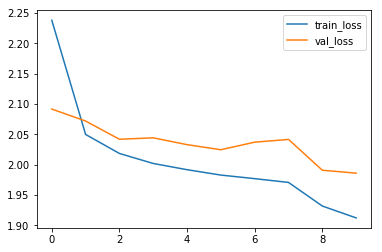

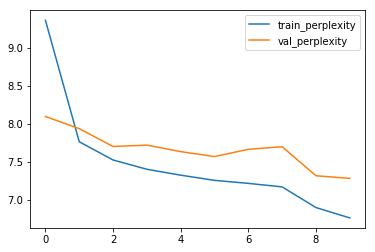

In [136]:
val_perplexity_final = train_state['val_perplexity'][-1]

print(f'Final perplexity on validation data: {np.round(val_perplexity_final, 2)}')
train_state_df = pd.DataFrame(train_state)
train_state_df.filter(regex='(train|val)_loss').plot()
train_state_df.filter(regex='(train|val)_perplexity').plot()
plt.show()

In [190]:
def calculate_probs(dataset, model, data_type='test',
                    batch_size=10):
    dataset.set_data_type(data_type)
    batch_generator = generate_batches(dataset=lm_dataset, 
                                   batch_size=batch_size,
                                   collate_fn=collate_fn,
                                   shuffle=False,
                                   drop_last=False,
                                   device=args.device)
    
    probs = []
    model.eval()
    
    for batch_dict in islice(batch_generator, 1):
        source_batch = batch_dict['source_batch']
        target_batch = batch_dict['target_batch']
        batch_lengths = batch_dict['batch_lengths']
        
        h_t = torch.zeros(1, source_batch.shape[0], 
                          model.rnn.hidden_size)
        
        with(torch.no_grad()):
            for time_step in range(source_batch.shape[1]):
                x_t = source_batch[:, time_step].unsqueeze(1)
                emb_t = model.embedding(x_t)
                rnn_out_t, h_t = model.rnn(emb_t, h_t)
                
                y_pred = model.fc1(rnn_out_t.squeeze(1))
                y_pred_proba = F.softmax(y_pred, dim=1)
                y_true_proba = y_pred_proba[range(source_batch.shape[0]), 
                                                  target_batch[:, time_step]]
                probs.append(y_true_proba)
        
        probs = torch.stack(probs, dim=1)
    
    return batch_dict, probs

In [223]:
def print_word_probs(batch_dict, probs):
    target_batch = batch_dict['target_batch']
    batch_lengths = batch_dict['batch_lengths']
       
    for sample_idx in range(target_batch.shape[0]):
        word_prob = 1.
        word = ''
        char_probs = ''
        
        for time_step in range(batch_lengths[sample_idx]):
            char_idx = target_batch[sample_idx, time_step].item()
            char = vectorizer.char_vocab.lookup_index(char_idx)
            char_prob = probs[sample_idx, time_step]
            
            word += char
            char_probs += f'{char}: {char_prob:.5f} '
            word_prob *= char_prob     
            
        print(word)
        print(char_probs)
        print(f'Word propability: {word_prob}\n')

In [224]:
batch_dict, test_probs = calculate_probs(lm_dataset, model, batch_size=5)
print_word_probs(batch_dict, test_probs)

своевременный<END>
с: 0.09771 в: 0.04814 о: 0.25881 е: 0.03328 в: 0.08659 р: 0.03992 е: 0.17182 м: 0.00663 е: 0.23240 н: 0.63696 н: 0.40620 ы: 0.89467 й: 0.99864 <END>: 0.94817 
Word propability: 8.132163345497823e-12

индексировать<END>
и: 0.02360 н: 0.12235 д: 0.08673 е: 0.27500 к: 0.02498 с: 0.09709 и: 0.12955 р: 0.34857 о: 0.76098 в: 0.82557 а: 0.87808 т: 0.46660 ь: 0.93799 <END>: 0.79058 
Word propability: 1.4400227676958366e-09

мальтийский<END>
м: 0.03920 а: 0.31618 л: 0.10899 ь: 0.13005 т: 0.12049 и: 0.11977 й: 0.02103 с: 0.19018 к: 0.87714 и: 0.89901 й: 0.98315 <END>: 0.93001 
Word propability: 7.3108257225840134e-09

расчленить<END>
р: 0.04852 а: 0.59851 с: 0.31260 ч: 0.02733 л: 0.01495 е: 0.04883 н: 0.06743 и: 0.35324 т: 0.24852 ь: 0.68994 <END>: 0.54859 
Word propability: 4.058234581716391e-10

лопаться<END>
л: 0.02237 о: 0.14441 п: 0.06485 а: 0.09252 т: 0.46924 ь: 0.14354 с: 0.26725 я: 0.97455 <END>: 0.99782 
Word propability: 3.393217014036054e-07



In [236]:
def generate_words(model, vectorizer, 
                   max_length=20,
                   batch_size=10):
    indices = []
    probs = []
    
    model.eval()
        
    h_t = torch.zeros(1, batch_size, 
                      model.rnn.hidden_size)

    x_t = torch.full((batch_size, 1), 
                     vectorizer.char_vocab.begin_index,
                     dtype=torch.int64)
        
    with torch.no_grad():
        for time_step in range(max_length):
            emb_t = model.embedding(x_t)
            rnn_out_t, h_t = model.rnn(emb_t, h_t)
            y_pred = model.fc1(rnn_out_t.squeeze(1))
            y_pred_proba = F.softmax(y_pred, dim=1)
            y_pred_idx_best = torch.multinomial(y_pred_proba, num_samples=1).squeeze(1)
            y_pred_proba_best = y_pred_proba[range(batch_size), y_pred_idx_best]

            indices.append(y_pred_idx_best)
            probs.append(y_pred_proba_best)
            x_t = y_pred_idx_best.unsqueeze(1)
        
    indices = torch.stack(indices, dim=1)
    probs = torch.stack(probs, dim=1)
    
    return best_indices, best_probs

In [246]:
def print_generated_word_probs(vectorizer,
                               indices, probs):
    batch_size = indices.shape[0]
    
    for sample_idx in range(batch_size):
        word_prob = 1.
        word = ''
        char_probs = ''
        
        for time_step in range(max_size):
            char_idx = best_indices[sample_idx, time_step].item()
            
            if char_idx == vectorizer.char_vocab.end_index:
                break
                
            char = vectorizer.char_vocab.lookup_index(char_idx)
            char_prob = best_probs[sample_idx, time_step]
            
            word += char
            char_probs += f'{char}: {char_prob:.5f} '
            word_prob *= char_prob
        
        print(word)
        print(char_probs)
        print(f'Word propability: {word_prob}')

In [247]:
indices, probs = generate_words(model, vectorizer)
print_generated_word_probs(vectorizer, indices, probs)

жезмать
ж: 0.01343 е: 0.23506 з: 0.08671 м: 0.07521 а: 0.34146 т: 0.18844 ь: 0.08018 
Word propability: 1.0623301704981714e-07
богнухный
б: 0.08190 о: 0.02504 г: 0.02381 н: 0.05829 у: 0.59593 х: 0.04144 н: 0.22768 ы: 0.26877 й: 0.99288 
Word propability: 4.270277464968331e-09
жержение
ж: 0.04393 е: 0.47637 р: 0.07109 ж: 0.04645 е: 0.68117 н: 0.54009 и: 0.30731 е: 0.68446 
Word propability: 5.346646048565162e-06
жездраивать
ж: 0.01664 е: 0.22691 з: 0.07062 д: 0.21253 р: 0.03980 а: 0.38419 и: 0.01287 в: 0.49339 а: 0.79916 т: 0.93401 ь: 0.97616 
Word propability: 4.008593013082873e-09
прогиваться
п: 0.24010 р: 0.56647 о: 0.35683 г: 0.05029 и: 0.08880 в: 0.05415 а: 0.22306 т: 0.88341 ь: 0.80292 с: 0.39698 я: 0.97624 
Word propability: 7.196476303761301e-07
тралий
т: 0.31609 р: 0.16353 а: 0.23768 л: 0.07282 и: 0.38772 й: 0.04657 
Word propability: 1.615312066860497e-05
тшитворок
т: 0.28890 ш: 0.00989 и: 0.33332 т: 0.30656 в: 0.01600 о: 0.25647 р: 0.25699 о: 0.22894 к: 0.03390 
Word propabil

In [146]:
best_indices = []
best_probs = []
batch_size = 10
max_size = 20

model.eval()
h_t = torch.rand(1, batch_size, args.hidden_size)
print(h_t.shape)

x_t = torch.full((batch_size, 1), 
                 vectorizer.char_vocab.begin_index,
                 dtype=torch.int64)

with torch.no_grad():
    for time_step in range(max_size):
        emb_t = model.embedding(x_t)
#         print(emb_t.shape)
        rnn_out_t, h_t = model.rnn(emb_t, h_t)
#         print(rnn_out_t.shape)
        y_pred = model.fc1(rnn_out_t.squeeze(1))
#         print(y_pred.shape)
        y_pred_proba = F.softmax(y_pred, dim=1)
#         print(y_pred_proba.shape)
        y_pred_idx_best = torch.multinomial(y_pred_proba, num_samples=1).squeeze(1)
#         print(y_pred_idx_best)
        y_pred_proba_best = y_pred_proba[range(batch_size), y_pred_idx_best]
#         print(y_pred_proba_best)
        
        best_indices.append(y_pred_idx_best)
        best_probs.append(y_pred_proba_best)
        x_t = y_pred_idx_best.unsqueeze(1)
#         print(x_t)
best_probs = torch.stack(best_probs, dim=1)
best_indices = torch.stack(best_indices, dim=1)
#best_probs, best_indices

torch.Size([1, 10, 50])


In [147]:
for sample_idx in range(batch_size):
    word = ''
    word_prob = 1.
    for time_step in range(max_size):
        char_idx = best_indices[sample_idx, time_step].item()
        if char_idx == vectorizer.char_vocab.end_index:
            break
        char = vectorizer.char_vocab.lookup_index(char_idx)
        word += char
        char_prob = best_probs[sample_idx, time_step]
        print(f'{char}: {char_prob}')
        word_prob *= char_prob
    print(f'Word : {word}')
    print(f'Word propability: {word_prob}')

ж: 0.013434505090117455
е: 0.23505818843841553
з: 0.08670786768198013
м: 0.0752064660191536
а: 0.34145569801330566
т: 0.1884392350912094
ь: 0.08017576485872269
Word : жезмать
Word propability: 1.0623301704981714e-07
б: 0.08189579099416733
о: 0.025043155997991562
г: 0.023806119337677956
н: 0.05829021707177162
у: 0.5959314703941345
х: 0.04144047945737839
н: 0.22767885029315948
ы: 0.2687692940235138
й: 0.992882251739502
Word : богнухный
Word propability: 4.270277464968331e-09
ж: 0.04392676800489426
е: 0.4763668179512024
р: 0.0710882917046547
ж: 0.046448271721601486
е: 0.6811736822128296
н: 0.5400915741920471
и: 0.3073054254055023
е: 0.6844592094421387
Word : жержение
Word propability: 5.346646048565162e-06
ж: 0.01663653366267681
е: 0.22691220045089722
з: 0.07062467187643051
д: 0.2125256359577179
р: 0.03980042040348053
а: 0.38419288396835327
и: 0.012869732454419136
в: 0.4933893084526062
а: 0.7991614937782288
т: 0.934010922908783
ь: 0.9761595129966736
Word : жездраивать
Word propability: 4.

In [137]:
lm_dataset.set_data_type('test')
lm_dataset._target_df.head(), len(lm_dataset)

(                word data_type
 11000    мальтийский      test
 11001     расчленить      test
 11002       лопаться      test
 11003  индексировать      test
 11004  своевременный      test, 1000)

In [138]:
batch_generator = generate_batches(dataset=lm_dataset, 
                                   batch_size=2,
                                   collate_fn=collate_fn,
                                   shuffle=False,
                                   drop_last=False,
                                   device=args.device)
for batch_dict in islice(batch_generator, 1):
    pass

batch_dict

{'source_batch': tensor([[ 2, 29,  5,  6, 21, 17, 11, 12,  9, 10, 11, 12],
         [ 2, 18,  5,  9, 15,  6, 13,  8, 11, 17, 21,  0]]),
 'target_batch': tensor([[29,  5,  6, 21, 17, 11, 12,  9, 10, 11, 12,  3],
         [18,  5,  9, 15,  6, 13,  8, 11, 17, 21,  3,  0]]),
 'batch_lengths': tensor([12, 11])}

In [139]:
source_batch = batch_dict['source_batch']
target_batch = batch_dict['target_batch']
batch_lengths = batch_dict['batch_lengths']

source_batch, target_batch, batch_lengths

(tensor([[ 2, 29,  5,  6, 21, 17, 11, 12,  9, 10, 11, 12],
         [ 2, 18,  5,  9, 15,  6, 13,  8, 11, 17, 21,  0]]),
 tensor([[29,  5,  6, 21, 17, 11, 12,  9, 10, 11, 12,  3],
         [18,  5,  9, 15,  6, 13,  8, 11, 17, 21,  3,  0]]),
 tensor([12, 11]))

In [141]:
model.eval()
h_t = torch.zeros(1, source_batch.shape[0], args.hidden_size)
print(h_t.shape)

probs = []
with(torch.no_grad()):
    for time_step in range(source_batch.shape[1]):
        x_t = source_batch[:, time_step].unsqueeze(1)
#         print(x_t.shape)
        emb_t = model.embedding(x_t)
#         print(emb_t.shape)
        rnn_out_t, h_t = model.rnn(emb_t, h_t)
#         print(rnn_out_t.shape, h_t.shape)
#         print(rnn_out_t.shape)
        y_pred = model.fc1(rnn_out_t.squeeze(1))
#         print(y_pred.shape)
        y_pred_proba = F.softmax(y_pred, dim=1)
        print(y_pred_proba.shape)
        y_true_proba = y_pred_proba[range(source_batch.shape[0]), 
                                          target_batch[:, time_step]]
#         print(y_true_proba.shape)
        probs.append(y_true_proba)
probs = torch.stack(probs, dim=1)
probs

torch.Size([1, 2, 50])
torch.Size([2, 56])
torch.Size([2, 56])
torch.Size([2, 56])
torch.Size([2, 56])
torch.Size([2, 56])
torch.Size([2, 56])
torch.Size([2, 56])
torch.Size([2, 56])
torch.Size([2, 56])
torch.Size([2, 56])
torch.Size([2, 56])
torch.Size([2, 56])


tensor([[3.9200e-02, 3.1618e-01, 1.0899e-01, 1.3005e-01, 1.2049e-01, 1.1977e-01,
         2.1030e-02, 1.9018e-01, 8.7714e-01, 8.9901e-01, 9.8315e-01, 9.3001e-01],
        [4.8516e-02, 5.9851e-01, 3.1260e-01, 2.7327e-02, 1.4954e-02, 4.8834e-02,
         6.7430e-02, 3.5324e-01, 2.4852e-01, 6.8994e-01, 5.4859e-01, 3.7015e-07]])

In [142]:
target_batch

tensor([[29,  5,  6, 21, 17, 11, 12,  9, 10, 11, 12,  3],
        [18,  5,  9, 15,  6, 13,  8, 11, 17, 21,  3,  0]])

In [143]:
for sample_idx in range(target_batch.shape[0]):
    word_prob = 1
    for time_step in range(batch_lengths[sample_idx]):
        char = vectorizer.char_vocab.lookup_index(target_batch[sample_idx, time_step].item())
        char_prob = probs[sample_idx, time_step]
        print(f'{char}: {char_prob}')
        word_prob *= char_prob
    print(f'Word propability: {word_prob}')

м: 0.039199721068143845
а: 0.3161849081516266
л: 0.10898789018392563
ь: 0.1300472617149353
т: 0.12049396336078644
и: 0.1197744756937027
й: 0.02102978527545929
с: 0.1901758760213852
к: 0.8771425485610962
и: 0.8990130424499512
й: 0.9831482172012329
<END>: 0.9300125241279602
Word propability: 7.310841709795568e-09
р: 0.04851634055376053
а: 0.5985133647918701
с: 0.3126019835472107
ч: 0.027326766401529312
л: 0.014953501522541046
е: 0.0488337017595768
н: 0.06742988526821136
и: 0.35324016213417053
т: 0.24851635098457336
ь: 0.689936637878418
<END>: 0.5485886931419373
Word propability: 4.0582420757218074e-10


In [146]:
best_indices = []
best_probs = []
batch_size = 10
max_size = 20

model.eval()
h_t = torch.rand(1, batch_size, args.hidden_size)
print(h_t.shape)

x_t = torch.full((batch_size, 1), 
                 vectorizer.char_vocab.begin_index,
                 dtype=torch.int64)

with torch.no_grad():
    for time_step in range(max_size):
        emb_t = model.embedding(x_t)
#         print(emb_t.shape)
        rnn_out_t, h_t = model.rnn(emb_t, h_t)
#         print(rnn_out_t.shape)
        y_pred = model.fc1(rnn_out_t.squeeze(1))
#         print(y_pred.shape)
        y_pred_proba = F.softmax(y_pred, dim=1)
#         print(y_pred_proba.shape)
        y_pred_idx_best = torch.multinomial(y_pred_proba, num_samples=1).squeeze(1)
#         print(y_pred_idx_best)
        y_pred_proba_best = y_pred_proba[range(batch_size), y_pred_idx_best]
#         print(y_pred_proba_best)
        
        best_indices.append(y_pred_idx_best)
        best_probs.append(y_pred_proba_best)
        x_t = y_pred_idx_best.unsqueeze(1)
#         print(x_t)
best_probs = torch.stack(best_probs, dim=1)
best_indices = torch.stack(best_indices, dim=1)
#best_probs, best_indices

torch.Size([1, 10, 50])


In [147]:
for sample_idx in range(batch_size):
    word = ''
    word_prob = 1.
    for time_step in range(max_size):
        char_idx = best_indices[sample_idx, time_step].item()
        if char_idx == vectorizer.char_vocab.end_index:
            break
        char = vectorizer.char_vocab.lookup_index(char_idx)
        word += char
        char_prob = best_probs[sample_idx, time_step]
        print(f'{char}: {char_prob}')
        word_prob *= char_prob
    print(f'Word : {word}')
    print(f'Word propability: {word_prob}')

ж: 0.013434505090117455
е: 0.23505818843841553
з: 0.08670786768198013
м: 0.0752064660191536
а: 0.34145569801330566
т: 0.1884392350912094
ь: 0.08017576485872269
Word : жезмать
Word propability: 1.0623301704981714e-07
б: 0.08189579099416733
о: 0.025043155997991562
г: 0.023806119337677956
н: 0.05829021707177162
у: 0.5959314703941345
х: 0.04144047945737839
н: 0.22767885029315948
ы: 0.2687692940235138
й: 0.992882251739502
Word : богнухный
Word propability: 4.270277464968331e-09
ж: 0.04392676800489426
е: 0.4763668179512024
р: 0.0710882917046547
ж: 0.046448271721601486
е: 0.6811736822128296
н: 0.5400915741920471
и: 0.3073054254055023
е: 0.6844592094421387
Word : жержение
Word propability: 5.346646048565162e-06
ж: 0.01663653366267681
е: 0.22691220045089722
з: 0.07062467187643051
д: 0.2125256359577179
р: 0.03980042040348053
а: 0.38419288396835327
и: 0.012869732454419136
в: 0.4933893084526062
а: 0.7991614937782288
т: 0.934010922908783
ь: 0.9761595129966736
Word : жездраивать
Word propability: 4.